In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext autoreload
%autoreload 2

import os 
import sys
import time

project_dir_path = '/home/onoue/ws/lukasiewicz_1'
sys.path.append(project_dir_path)

for path in sys.path:
    print(path)

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import cvxpy as cp

from src.setup_problem_modular import Setup
from src.objective_function import specimen_construct_objective_function                                        
from src.objective_function import specimen_construct_objective_function_loss                                        
from src.misc import visualize_result

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/onoue/ws/lukasiewicz_1/notebooks/toy_problem
/usr/lib/python310.zip
/usr/lib/python3.10
/usr/lib/python3.10/lib-dynload

/home/onoue/ws/lukasiewicz_1/myenv/lib/python3.10/site-packages
/home/onoue/ws/lukasiewicz_1


load_data took 0.051232337951660156 seconds!
load_rules took 0.0006775856018066406 seconds!
specimen_construct_objective_function_loss took 0.05232858657836914 seconds!
consistency constraints
__call__ took 0.025907278060913086 seconds!
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Dec 09 07:27:18 PM: Your problem has 23 variables, 60 constraints, and 0 parameters.
(CVXPY) Dec 09 07:27:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 09 07:27:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 09 07:27:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 09 07:27:18 PM: Compiling problem (target solver=ECOS).
(CVXPY) Dec 09 07:27:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Dec 09 07:27:18 PM: Applying reduction Dcp2Cone
(CVXPY) Dec 09 07:27:18 PM: Applying reduction CvxAttr2Constr
(CVXPY) Dec 09 07:27:18 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Dec 09 07:27:18 PM: Applying reduction ECOS
(CVXPY) Dec 09 07:27:18 PM: Finished problem compilation (took 3.897e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Dec 09 07:27:18 PM: Inv

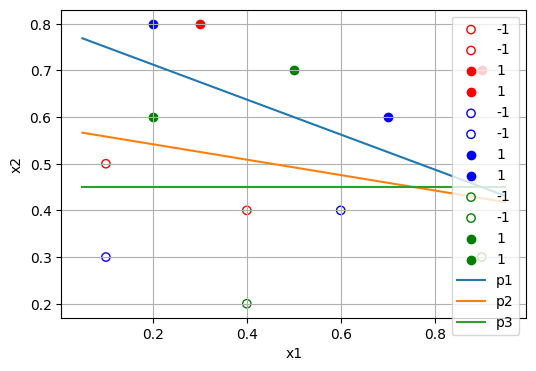

In [7]:
from src.objective_function import specimen_construct_objective_function_loss

file_names_dict = {
    "supervised": ["L_p1(x).csv", "L_p2(x).csv", "L_p3(x).csv"],
    "unsupervised": ["U.csv"],
    "rule": ["rules.txt"]
}

data_dir_path = './../../inputs/toy_data'
data_dir_path = './../../inputs/toy_data/'

obj_constructor = specimen_construct_objective_function_loss

constraints_flag_dict = {
    "pointwise"  : False,
    "logical"    : False,
    "consistency": True
}
# constraints_flag_dict = None


# c1 = 2.5
# c2 = 2.5
c1 = 100
c2 = 100

problem_instance = Setup(data_dir_path, file_names_dict, obj_constructor)
objective, constraints = problem_instance.main(constraints_flag_dict=constraints_flag_dict,
                                               c1=c1,
                                               c2=c2)


problem = cp.Problem(objective, constraints)
result = problem.solve(verbose=True)

visualize_result(problem_instance)

In [14]:
data_dir_path

'/home/onoue/ws/lukasiewicz_1/inputs/pima_indian_diabetes'

In [15]:
from src.setup_problem_modular import Setup
from src.objective_function import specimen_construct_objective_function

data_dir_path = os.path.join(project_dir_path, 'inputs/pima_indian_diabetes')
train_data_dir_path = os.path.join(data_dir_path, "train_4")
file_list = os.listdir(train_data_dir_path)

L_files = [filename for filename in file_list 
           if filename.startswith('L') and filename.endswith('.csv')]

U_files = [filename for filename in file_list 
           if filename.startswith('U') and filename.endswith('.csv')]

file_names_dict = {
    'supervised': L_files,
    'unsupervised': U_files,
    'rule': ['rules.txt']
}

obj_constructor = specimen_construct_objective_function

constraints_flag_dict = {
    "pointwise"  : False,
    "logical"    : False,
    "consistency": True
}
# constraints_flag_dict = None


# c1 = 2.5
# c2 = 2.5
c1 = 100
c2 = 100

problem_instance = Setup(train_data_dir_path, file_names_dict, obj_constructor)
objective, constraints = problem_instance.main(constraints_flag_dict=constraints_flag_dict,
                                               c1=c1,
                                               c2=c2)

start_time = time.time()
problem = cp.Problem(objective, constraints)
result = problem.solve(verbose=True)
end_time = time.time()
print()
print(f'学習時間: {end_time - start_time} 秒')


print()
print()
print()


test_data_dir_path = os.path.join(data_dir_path, "test_4")
file_path = os.path.join(test_data_dir_path, "L_Outcome.csv")
test_df = pd.read_csv(file_path, index_col=0)
display(test_df.head())

test_data = {
    'Outcome': np.array(test_df)
}

p_dict = problem_instance.predicates_dict
selected_predicates = ['Outcome']
selected_p_dict = {key: value for key, value in p_dict.items() if key in selected_predicates}

X_test = test_data['Outcome'][:, :-1]
y_test = test_data['Outcome'][:, -1]

y_pred = p_dict['Outcome'](X_test).value

y_pred_interpreted = np.where(y_pred >= 0.5, 1, -1)

accuracy = accuracy_score(y_test, y_pred_interpreted)
print("Accuracy: ")
print(accuracy)
print()

conf_matrix = confusion_matrix(y_test, y_pred_interpreted)
print("Confusion matrix: ")
print(conf_matrix)
print()

class_report = classification_report(y_test, y_pred_interpreted)
print("classification report: ")
print(class_report)
print()

roc_auc = roc_auc_score(y_test, y_pred)
print("auc: ")
print(roc_auc)

load_data took 0.24684596061706543 seconds!
load_rules took 0.0016858577728271484 seconds!
specimen_construct_objective_function took 8.043935537338257 seconds!
consistency constraints
__call__ took 13.312123537063599 seconds!


/home/onoue/ws/lukasiewicz_1/myenv/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Dec 10 06:45:28 AM: Your problem has 12014 variables, 24464 constraints, and 0 parameters.
(CVXPY) Dec 10 06:45:30 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 10 06:45:30 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 10 06:45:30 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 10 06:45:33 AM: Compiling problem (target solver=ECOS).
(CVXPY) Dec 10 06:45:33 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuf

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,target
419,3,129,64,29,26.4,0.219,28,1
186,8,181,68,36,30.1,0.615,60,1
556,1,97,70,40,38.1,0.218,30,-1
738,2,99,60,17,36.6,0.453,21,-1
320,4,129,60,12,27.5,0.527,31,-1


Accuracy: 
0.6716417910447762

Confusion matrix: 
[[90  0]
 [44  0]]

classification report: 
              precision    recall  f1-score   support

        -1.0       0.67      1.00      0.80        90
         1.0       0.00      0.00      0.00        44

    accuracy                           0.67       134
   macro avg       0.34      0.50      0.40       134
weighted avg       0.45      0.67      0.54       134


auc: 
0.8393939393939394


/home/onoue/ws/lukasiewicz_1/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onoue/ws/lukasiewicz_1/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onoue/ws/lukasiewicz_1/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [16]:
from src.setup_problem_modular import Setup
from src.objective_function import specimen_construct_objective_function_loss

data_dir_path = os.path.join(project_dir_path, 'inputs/pima_indian_diabetes')
train_data_dir_path = os.path.join(data_dir_path, "train_4")
file_list = os.listdir(train_data_dir_path)

L_files = [filename for filename in file_list 
           if filename.startswith('L') and filename.endswith('.csv')]

U_files = [filename for filename in file_list 
           if filename.startswith('U') and filename.endswith('.csv')]

file_names_dict = {
    'supervised': L_files,
    'unsupervised': U_files,
    'rule': ['rules.txt']
}

obj_constructor = specimen_construct_objective_function_loss

constraints_flag_dict = {
    "pointwise"  : False,
    "logical"    : False,
    "consistency": True
}
# constraints_flag_dict = None


# c1 = 2.5
# c2 = 2.5
c1 = 100
c2 = 100

problem_instance = Setup(train_data_dir_path, file_names_dict, obj_constructor)
objective, constraints = problem_instance.main(constraints_flag_dict=constraints_flag_dict,
                                               c1=c1,
                                               c2=c2)

start_time = time.time()
problem = cp.Problem(objective, constraints)
result = problem.solve(verbose=True)
end_time = time.time()
print()
print(f'学習時間: {end_time - start_time} 秒')


print()
print()
print()


test_data_dir_path = os.path.join(data_dir_path, "test_4")
file_path = os.path.join(test_data_dir_path, "L_Outcome.csv")
test_df = pd.read_csv(file_path, index_col=0)
display(test_df.head())

test_data = {
    'Outcome': np.array(test_df)
}

p_dict = problem_instance.predicates_dict
selected_predicates = ['Outcome']
selected_p_dict = {key: value for key, value in p_dict.items() if key in selected_predicates}

X_test = test_data['Outcome'][:, :-1]
y_test = test_data['Outcome'][:, -1]

y_pred = p_dict['Outcome'](X_test).value

y_pred_interpreted = np.where(y_pred >= 0.5, 1, -1)

accuracy = accuracy_score(y_test, y_pred_interpreted)
print("Accuracy: ")
print(accuracy)
print()

conf_matrix = confusion_matrix(y_test, y_pred_interpreted)
print("Confusion matrix: ")
print(conf_matrix)
print()

class_report = classification_report(y_test, y_pred_interpreted)
print("classification report: ")
print(class_report)
print()

roc_auc = roc_auc_score(y_test, y_pred)
print("auc: ")
print(roc_auc)

load_data took 0.11600399017333984 seconds!
load_rules took 0.00054168701171875 seconds!
specimen_construct_objective_function_loss took 45.30561184883118 seconds!
consistency constraints
__call__ took 19.412967205047607 seconds!


/home/onoue/ws/lukasiewicz_1/myenv/lib/python3.10/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Dec 10 06:49:42 AM: Your problem has 12014 variables, 24464 constraints, and 0 parameters.
(CVXPY) Dec 10 06:49:47 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 10 06:49:47 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 10 06:49:47 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 10 06:49:54 AM: Compiling problem (target solver=ECOS).
(CVXPY) Dec 10 06:49:54 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuf

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,target
419,3,129,64,29,26.4,0.219,28,1
186,8,181,68,36,30.1,0.615,60,1
556,1,97,70,40,38.1,0.218,30,-1
738,2,99,60,17,36.6,0.453,21,-1
320,4,129,60,12,27.5,0.527,31,-1


Accuracy: 
0.6716417910447762

Confusion matrix: 
[[90  0]
 [44  0]]

classification report: 
              precision    recall  f1-score   support

        -1.0       0.67      1.00      0.80        90
         1.0       0.00      0.00      0.00        44

    accuracy                           0.67       134
   macro avg       0.34      0.50      0.40       134
weighted avg       0.45      0.67      0.54       134


auc: 
0.21792929292929294


/home/onoue/ws/lukasiewicz_1/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onoue/ws/lukasiewicz_1/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onoue/ws/lukasiewicz_1/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r